In [53]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter

In [54]:
new_saver = tf.train.import_meta_graph('../models/dec-10/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/dec-10/'))

INFO:tensorflow:Restoring parameters from ../models/dec-10/model


In [97]:
data_x = np.load("../data/processed/data_x_l2a_processed.npy")
data_y = np.load("../data/processed/data_y_l2a_processed.npy")
lengths = np.load("../data/processed/length_l2a_processed.npy")

min_all = []
max_all = []
for band in range(0, data_x.shape[-1]):

    mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The data has been scaled to [-1.0000000000000002, 1.0]


In [98]:
min_all

[-0.007127528108046845,
 -0.006308276790750921,
 -0.005943539344072567,
 -0.014076325659769663,
 -0.01691662922826153,
 -0.012223100234723193,
 0.0018522246124179904,
 -0.01430497496774622,
 -0.003110283495173354,
 -0.0004207581592294083,
 0.0,
 -0.2420451234460339,
 -0.6443897846922992,
 -0.1872664223836895,
 0.5175425112214429]

In [111]:
test_x = np.load("../data/processed/test_x_l2a_processed.npy")
test_y = np.load("../data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../data/processed/test_length_l2a_processed.npy")

#test_x = np.delete(test_x, 11, -1)
#test_x = np.delete(test_x, 13, -1)


below_1 = [i for i, val in enumerate(test_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(test_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(test_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)

for i in range(len(test_x)):
    mins = np.min(test_x[i, :, :, :, :])
    maxs = np.max(test_x[i, :, :, :, :])
    if mins < -1 or maxs > 1:
        offender_max = np.argmax(np.max(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        offender_min = np.argmin(np.min(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        
        print("{} Offender max/min: {} {}".format(i, offender_max, offender_min))
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]
print(np.min(test_x[19]))

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [], totalling 0


[] []
-0.18747019243077978



The data has been scaled to [-1.0000000000000002, 0.9634321392015605]
(173, 24, 16, 16, 15)


In [112]:
for i in range(50):
    try:
        fm = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [113]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
labels = tf.get_default_graph().get_tensor_by_name("Placeholder_2:0")

In [114]:
%run ../src/utils.py

In [115]:

def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    test_ids = [x for x in test_ids if x not in [158, 105]]
    for test_sample in test_ids:
        y = sess.run([fm], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, 15),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y[0].reshape((14, 14)))
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    #to_remove = np.argwhere(vls > np.percentile(vls, 95))
    #print(len(to_remove))
    #ys = list(np.delete(np.array(ys), to_remove, 0))
    #t_alls = list(np.delete(np.array(t_alls), to_remove, 0))
    for thresh in range(6, 13):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        #val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            #vl = vls[sample]
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)

            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            #val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        print(thresh*0.05, oa_error, f1, recall)
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
            to_return = fns
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(3, np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(r, 3), np.around(p, 3), 
                                                                                     np.around(error, 3)))
    return best_f1, to_return

In [110]:
print("Bicubic")
best_f1, fns = calculate_metrics()

Bicubic
0.30000000000000004 0.3965473470423965 0.6815677966101694 0.8167047473978167
0.35000000000000003 0.2328002030972328 0.6890278567367824 0.7692307692307693
0.4 0.09926377253109926 0.6890796952473092 0.7232800203097233
0.45 0.0165016501650165 0.680532445923461 0.6749174917491749
0.5 0.11297283574511298 0.6667563567872999 0.6290936785986291
0.55 0.19954303122619954 0.6542583192329386 0.588981975120589
0.6000000000000001 0.27405432850977407 0.6410237552401264 0.5531860878395531
Val loss: 3 Thresh: 0.4 F1: 0.689 Recall: 0.723 Precision: 0.658 Error: 0.099


In [104]:
print("Superresolve")
best_f1, fns = calculate_metrics()

Superresolve
0.30000000000000004 0.5450621985275451 0.6614463840399002 0.8417110941863417
0.35000000000000003 0.37763391723787765 0.6700122791094976 0.7965219598882965
0.4 0.23064229499873065 0.6744437489330222 0.7522213759837523
0.45 0.10015232292460015 0.6733152009670595 0.707032241685707
0.5 0.018532622493018534 0.669314541960282 0.6631124650926631
0.55 0.1254125412541254 0.6629198266522209 0.6213505965981213
0.6000000000000001 0.2242955064737243 0.6519408106369291 0.5788271134805788
Val loss: 3 Thresh: 0.4 F1: 0.674 Recall: 0.752 Precision: 0.611 Error: 0.231


In [116]:
print("validated size")
best_f1, fns = calculate_metrics()

validated size
0.30000000000000004 0.3401878649403402 0.6836623996528531 0.7999492256917999
0.35000000000000003 0.19471947194719472 0.6899942163100058 0.7571718710332572
0.4 0.07197258187357197 0.6860258530907308 0.7107133790302107
0.45 0.036811373445036814 0.6760636234320444 0.6636202081746636
0.5 0.13125158669713125 0.6632251052846081 0.6197004315816197
0.55 0.21744097486671743 0.6505732393363242 0.5798425996445798
0.6000000000000001 0.29334856562579337 0.6330978058757903 0.5402386392485402
Val loss: 3 Thresh: 0.35 F1: 0.69 Recall: 0.757 Precision: 0.634 Error: 0.195


In [117]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show
start = 46

0.31213872832369943
54
55
56
57


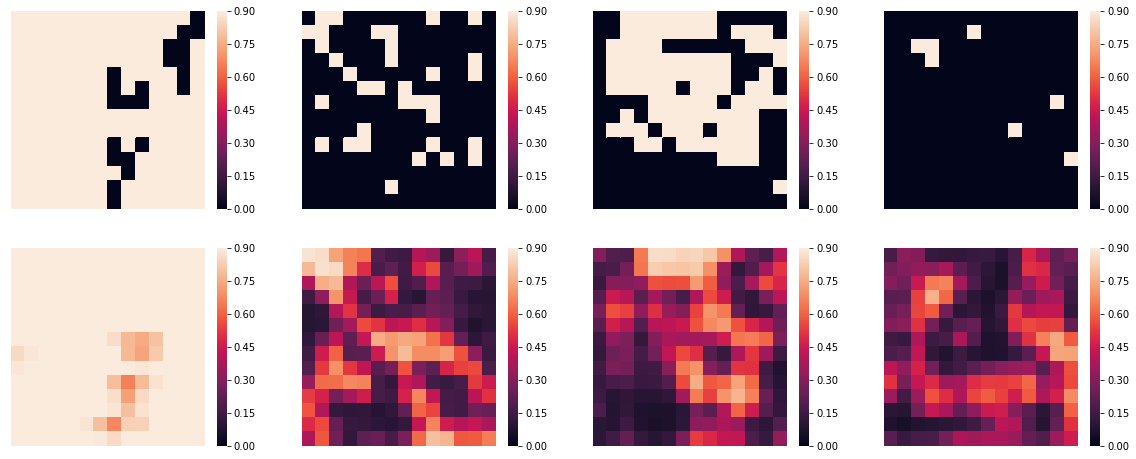

In [120]:
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3]]
              #test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, 16, 16, 15),
                                  length: test_lengths[idx].reshape(1, 1),
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.5)] = 1.0
    preds.append(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)
    ""
""
to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[/ordering[976]//4] 
start = start + 4 # 50, 87, 107 is a concern

# 513  - 135345883 image issues? CONFIRMED
# remove 608 - 135346016 (ambiguous labelling)

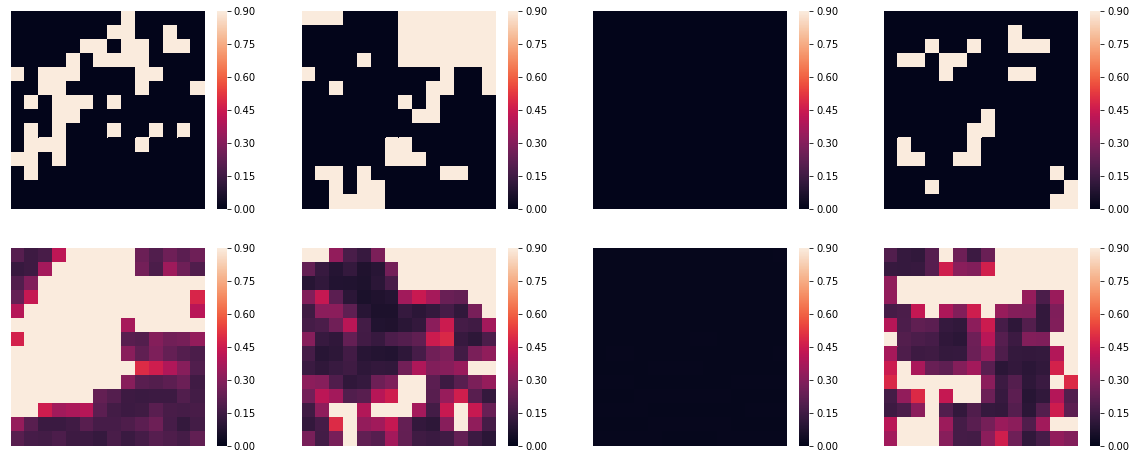

In [36]:
multiplot(to_plot, nrows = 2, ncols = 4)